# NOAA Interpolated Feature Data Explore

In [1]:
feature_data_dir = '../data/features'
processed_data_dir = '../data/processed'
media_dir = '../media'
figsize_width = 12
figsize_height = 8
output_dpi = 72

In [2]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Variable setup
default_fig_size = (figsize_width, figsize_height)

In [4]:
# Load data
# - NOAA
data_to_load = ['surface', 'aloft', 'diff']
feature_data = dict()
for nm in data_to_load:
    fname = os.path.join(feature_data_dir, 'noaa_{}_interpolated_data.pkl'.format(nm))
    with open(fname, 'rb') as fin:
        feature_data[nm] = pickle.load(fin)

# - NASA
data_to_load = ['temperature_anomaly', 'sea_level', 'carbon_dioxide_levels']
nasa_data = dict()
for nm in data_to_load:
    fname = os.path.join(processed_data_dir, 'nasa_{}.pkl'.format(nm))
    with open(fname, 'rb') as fin:
        nasa_data[nm] = pickle.load(fin)

# - Hurricane data
fname = os.path.join(processed_data_dir, 'region_data.pkl')
with open(fname, 'rb') as fin:
    region_data = pickle.load(fin)

fname = os.path.join(processed_data_dir, 'region_yearly_data.pkl')
with open(fname, 'rb') as fin:
    region_yearly_df = pickle.load(fin)

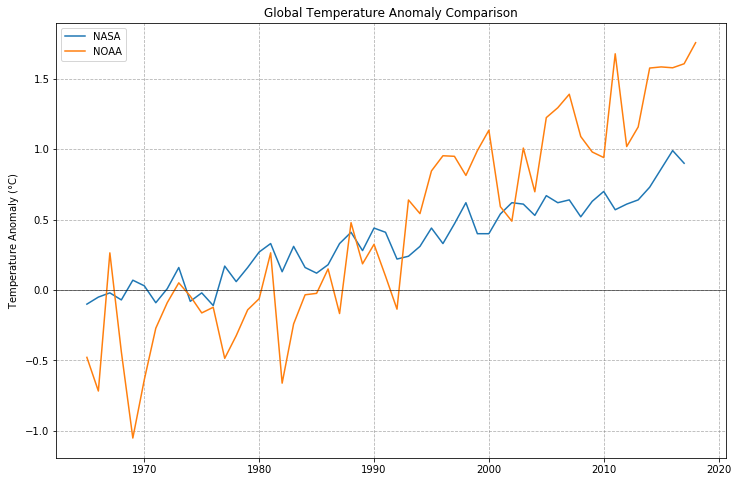

,NASA,NOAA
NASA,1.000000,0.865947
NOAA,0.865947,1.000000


In [5]:
# - Sanity check against NASA anomaly data just to see if we're close
nasa_tanom = nasa_data['temperature_anomaly'].copy().loc[:, 'Annual Mean']
nasa_tanom.name = 'NASA'

noaa_tanom = dict()
for k, v in feature_data['surface'].items():
    noaa_tanom[k] = v.flatten().mean()
noaa_tanom = pd.DataFrame.from_dict(noaa_tanom, orient='index', columns=['NOAA'])
noaa_tanom = noaa_tanom.groupby(noaa_tanom.index.year).mean()

fst_idx = max(noaa_tanom.first_valid_index(), nasa_tanom.first_valid_index())
tanom = pd.concat([nasa_tanom, noaa_tanom], axis=1).loc[fst_idx:]

# - Plot
fig, ax = plt.subplots(figsize=default_fig_size)

tanom.plot(ax=ax)
ax.axhline(0., color='black', linewidth=0.5)

ax.grid(True, linestyle='--', color='grey', alpha=0.6)
ax.set_title('Global Temperature Anomaly Comparison')
ax.set_ylabel('Temperature Anomaly ($\degree$C)')

fig.savefig(os.path.join(media_dir, 'nasa_noaa_anomaly_compare.png'), dpi=output_dpi)
plt.show();

# - Correlation table
tanom.corr()

In [6]:
# - Get data in regions of interest
region_cuts = {
    'North Atlantic': [(-90, 15), (0, 30)],
    'East Pacific': [(-120, -80), (0, 30)],
    'Western Pacific': [(120, 180), (-30, 30)],
    'Indian Ocean': [(45, 100), (-30, 30)]
}

cut_feature_data = dict()
for nm in feature_data.keys():
    cut_feature_data[nm] = dict()
    for region, bounds in region_cuts.items():
        long_bnd, lat_bnd = bounds[0], bounds[1]
        cut_feature_data[nm][region] = dict()
        for k, v in feature_data[nm].items():
            cut_feature_data[nm][region][pd.to_datetime(k)] = \
                feature_data[nm][k][long_bnd[0]+180:long_bnd[1]+180, 
                                    lat_bnd[0]+90:lat_bnd[1]+90]

In [7]:
# - Variables for plotting
colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']
color_dict = dict(zip(region_cuts.keys(), colors))

In [8]:
# - Average the data across regions
average_data = dict()
for nm in cut_feature_data.keys():
    t_regdat = list()
    for region in region_cuts.keys():
        t_data = cut_feature_data[nm][region]
        o_data = dict()
        for dt, vals in t_data.items():
            if vals.size == 0:
                continue
            o_data[dt] = vals.flatten().mean()
        if len(o_data) == 0:
            continue
        t_frame = pd.DataFrame.from_dict(o_data, orient='index')
        t_frame.columns = [region]
        t_regdat.append(t_frame)
    average_data[nm] = pd.concat(t_regdat, axis=1, sort=True)

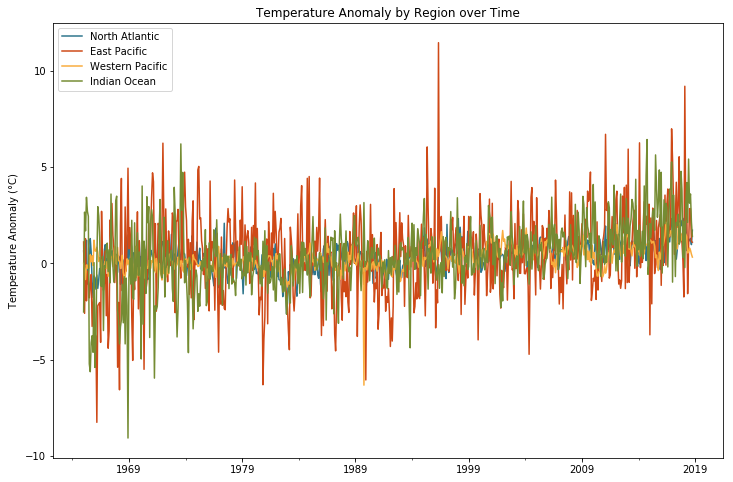

In [9]:
# - Plot
fig, ax = plt.subplots(figsize=default_fig_size)

average_data['diff'].plot(ax=ax, color=colors)

ax.set_ylabel('Temperature Anomaly ($\degree$C)')
ax.set_title('Temperature Anomaly by Region over Time')

plt.show();

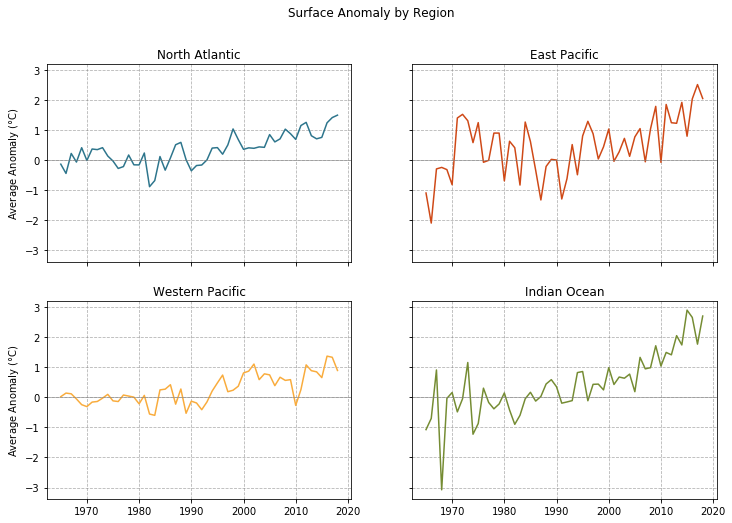

In [10]:
# - Average over years to remove seasonality (Surface)
nm = 'surface'
title = 'Surface Anomaly by Region'

data_to_plot = average_data[nm]
data_to_plot = data_to_plot.groupby(data_to_plot.index.year, axis=0).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, 
                        figsize=default_fig_size)

i_ax = 0
for col in data_to_plot.columns:
    ax = axs.flatten()[i_ax]
    
    data_to_plot.loc[:, col].plot(ax=ax, color=color_dict[col], label=col)

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.grid(True, color='grey', alpha=0.6, linestyle='--')
    
    ax.set_ylabel('Average Anomaly ($\degree$C)')
    ax.set_title(col)
    
    i_ax += 1

fig.suptitle(title)
fig.savefig(os.path.join(media_dir, 'noaa_{}_anomaly_by_region.png'.format(nm)), 
            dpi=output_dpi)
plt.show();

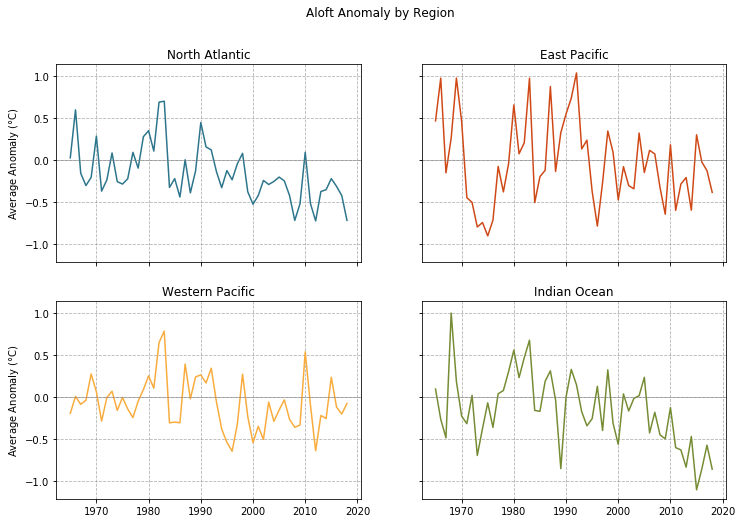

In [11]:
# - Average over years to remove seasonality (Aloft)
nm = 'aloft'
title = 'Aloft Anomaly by Region'

data_to_plot = average_data[nm]
data_to_plot = data_to_plot.groupby(data_to_plot.index.year, axis=0).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, 
                        figsize=default_fig_size)

i_ax = 0
for col in data_to_plot.columns:
    ax = axs.flatten()[i_ax]
    
    data_to_plot.loc[:, col].plot(ax=ax, color=color_dict[col], label=col)

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.grid(True, color='grey', alpha=0.6, linestyle='--')
    
    ax.set_ylabel('Average Anomaly ($\degree$C)')
    ax.set_title(col)
    
    i_ax += 1

fig.suptitle(title)
fig.savefig(os.path.join(media_dir, 'noaa_{}_anomaly_by_region.png'.format(nm)), 
            dpi=output_dpi)
plt.show();

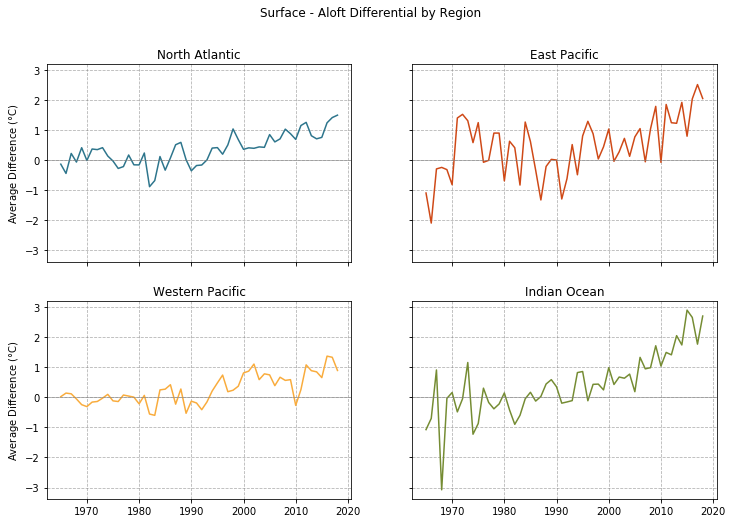

In [12]:
# - Average over years to remove seasonality (Difference)
nm = 'diff'
title = 'Surface - Aloft Differential by Region'

data_to_plot = average_data[nm]
data_to_plot = data_to_plot.groupby(data_to_plot.index.year, axis=0).mean()

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, 
                        figsize=default_fig_size)

i_ax = 0
for col in data_to_plot.columns:
    ax = axs.flatten()[i_ax]
    
    data_to_plot.loc[:, col].plot(ax=ax, color=color_dict[col], label=col)

    ax.axhline(0, color='grey', linewidth=0.5)
    ax.grid(True, color='grey', alpha=0.6, linestyle='--')
    
    ax.set_ylabel('Average Difference ($\degree$C)')
    ax.set_title(col)
    
    i_ax += 1

fig.suptitle(title)
fig.savefig(os.path.join(media_dir, 'noaa_{}_anomaly_by_region.png'.format(nm)), 
            dpi=output_dpi)
plt.show();